In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
gamma = 0.7
# wealth level
eps = 0.01
k_low = 1
k_high = 10
# interest rate
r = 0.05
# depreciation
delta = 0.3
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ks = np.linspace(k_low, k_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vs_new = np.copy(Vs)+1
# Value iteration
for j in range(1000):
    if j % 10 == 0:
        print(j)
    if max(abs(Vs_new - Vs)) < eps:
        print("converge! ")
        break 
    else:
        Vs = np.copy(Vs_new)
    for i in range(len(ks)):
        k = ks[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((1-delta)*k + (1+r)*(k**gamma - c), ks, Vs) + 
                     np.interp((1-delta)*k + (1-r)*(k**gamma - c), ks, Vs))/2)
        bounds = [(0, k**gamma)]
        res = minimize(obj, eps, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs_new[i] = -res.fun

0
10
20
30
40
50
60
70
converge! 


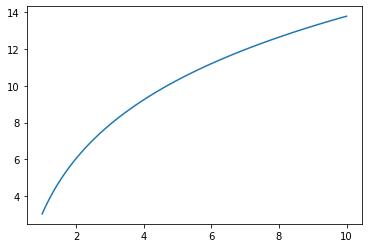

In [3]:
plt.plot(ks,Vs)

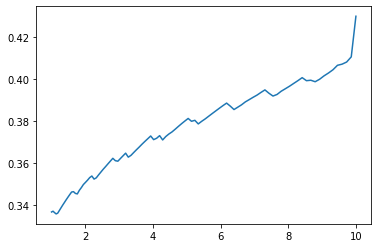

In [4]:
plt.plot(ks, Cs/ks**gamma)

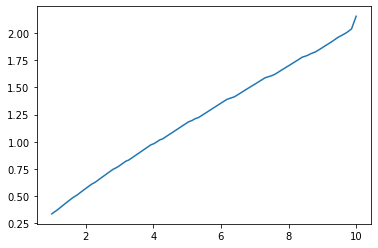

In [5]:
plt.plot(ks,Cs)

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ Beta($\alpha$, $\beta$)


Assume the initial value $a_1 = 0$, $b_1 = 0$, $c_1 = 0$, $d_1 = 0$, $a_2 = 0$, $b_2 = 0$, $c_2 = 0$, $d_2 = 0$:
$$\alpha = log(1+ e^{a_1 x^3 + b_1 x^2 + c_1 x + d_1}) + 1 $$
$$\beta = log(1+ e^{a_2 x^3 + b_2 x^2 + c_2 x + d_2}) + 1 $$


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [30]:
T = 50
def poly(the, w):
    value = the[0]*(w**3) + the[1]*(w**2) +the[2]*w + the[3]
    if isscalar(value):
        return max(min(value, 2**32),0)
    else:
        np.clip(value, 0, 2**32, out=value)
        return value

# simulation step T = 100
def a(theta, w):
    value = np.log(1+np.exp(poly(theta[:4],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value

def b(theta, w):
    value = np.log(1+np.exp(poly(theta[4:],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value


def simSinglePath(theta):
    kPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    k = np.random.uniform(k_low, k_high)
    for t in range(T):
        n = np.random.beta(a(theta, k), b(theta, k))
        n = max(min(n,1-eps),eps)
        c = n*(k**gamma)
        kPath[t] = k
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            k = (1-delta)*k + (k**gamma-c) * (1+r)
        else:
            k = (1-delta)*k + (k**gamma-c) * (1-r)
    return kPath, aPath, rPath

def gradientV(theta, D = 1000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum(np.log(ap)*(wp**3)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[1] = np.sum(np.log(ap)*(wp**2)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[2] = np.sum(np.log(ap)*(wp)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[3] = np.sum(np.log(ap)*(1)/(1+np.exp(-poly(theta[:4],wp))))            
            
            newGrad[4] = np.sum(np.log(1-ap)*(wp**3)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[5] = np.sum(np.log(1-ap)*(wp**2)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[6] = np.sum(np.log(1-ap)*(wp)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[7] = np.sum(np.log(1-ap)*(1)/(1+np.exp(-poly(theta[4:],wp))))
                  
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ks, Cs, 'b')
    plt.plot(ks, a(theta,ks)/(a(theta,ks) + b(theta,ks))*(ks**gamma), 'r')

0
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
1
[-0.08936685  0.40129706  0.48304773  0.49701561 -0.08879348  0.40138545
  0.48306341  0.49701896]
2
[-0.43714007  0.34798684  0.47396427  0.49530465 -0.42901304  0.34915351
  0.47415091  0.49533871]
3
[-0.7034566   0.31025666  0.46808094  0.4942812  -0.69779608  0.31130205
  0.4682737   0.49431915]
4
[-0.95435891  0.27454378  0.46246993  0.49329808 -0.95172336  0.27527763
  0.46263757  0.49333693]
5
[-1.21303268  0.23793002  0.45677277  0.49231188 -1.20896837  0.23907722
  0.45702845  0.49236945]
6
[-1.46605648  0.20184029  0.45109073  0.49131373 -1.46568307  0.20261452
  0.45131575  0.49137161]
7
[-1.70429881  0.16755588  0.44565664  0.49035334 -1.70981101  0.16770845
  0.44581224  0.49040323]
8
[-1.94905719  0.13253974  0.44011164  0.48937176 -1.95832492  0.13218288
  0.4401994   0.48941365]
9
[-2.20999651  0.09597166  0.43444394  0.48839168 -2.21680992  0.09599853
  0.43460186  0.48844915]


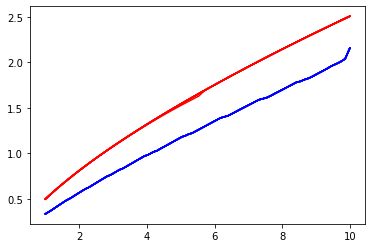

In [37]:
# initial theta 
N = 10
theta = [0.5]*8
# gradient ascend step size 
alpha = 0.00001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%1 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)